In [67]:
#!pip install google-colab

In [68]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import color
from skimage.color import rgb2gray, rgb2hsv
from scipy import stats
import imageio
import mpmath
from PIL import Image
from google.colab import drive
import os
import scipy.stats

from google.colab.patches import cv2_imshow # Import the Colab patch for imshow
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [69]:
drive.mount('/content/drive') # Mount Google Drive to access files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# Define paths (adjust according to your Google Drive structure)
img_paths = {
    'train': '/content/drive/My Drive/img/image-35.jpg',
    'val': '/content/drive/My Drive/img/image-83.jpg',
    'test': '/content/drive/My Drive/img/image-110.jpg'
}

mask_paths = {
    'train': '/content/drive/My Drive/mask/mask-35.png',
    'val': '/content/drive/My Drive/mask/mask-83.png',
    'test': '/content/drive/My Drive/mask/mask-110.png'
}

In [71]:
def read_images_and_masks(img_paths, mask_paths):
    images = {}
    masks = {}

    for key, img_path in img_paths.items():
        # Read the image in color
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        images[key] = img

        # Read the mask in grayscale
        mask = cv2.imread(mask_paths[key], cv2.IMREAD_GRAYSCALE)
        masks[key] = mask

    return images, masks

In [72]:
# Call the function
images, masks = read_images_and_masks(img_paths, mask_paths)

In [73]:
# Example of accessing one image and mask
print('Training Image shape:', images['train'].shape)
print('Training Mask shape:', masks['train'].shape)

Training Image shape: (450, 600, 3)
Training Mask shape: (450, 600)


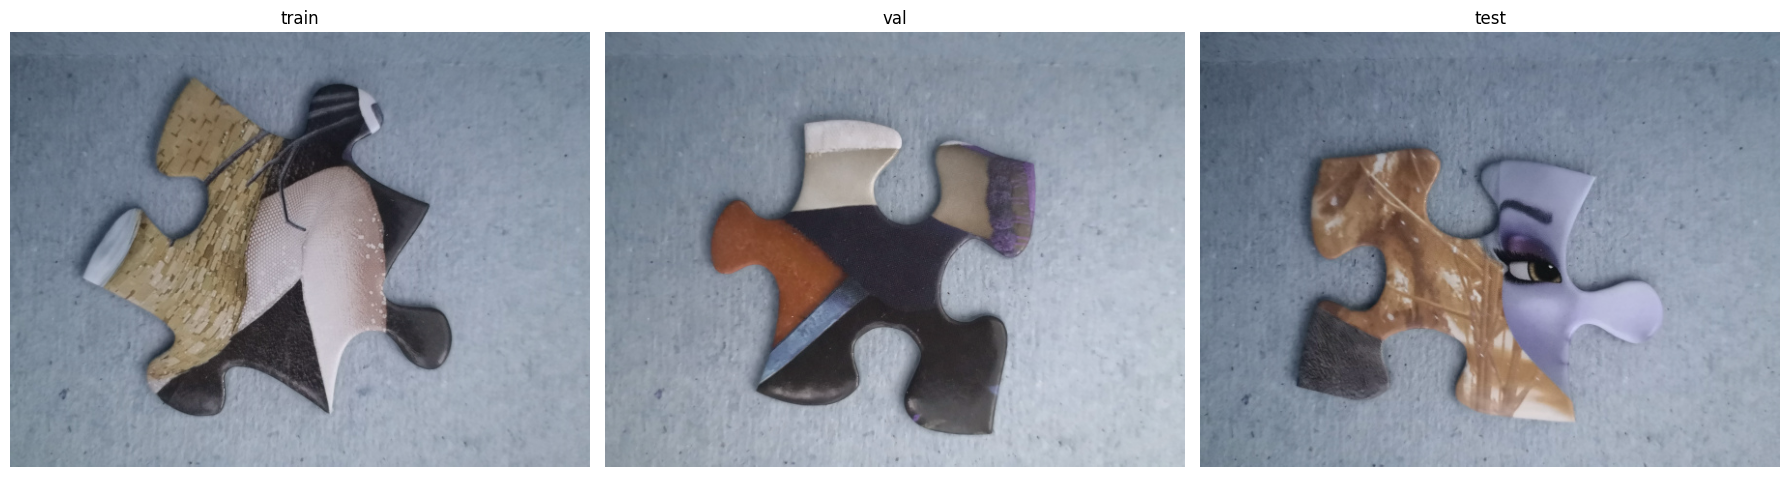

In [74]:
def display_color_images(images):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (key, img) in enumerate(images.items()):
        axes[i].imshow(img)  # Directly use BGR image
        axes[i].set_title(f'{key}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display the color images
display_color_images(images)

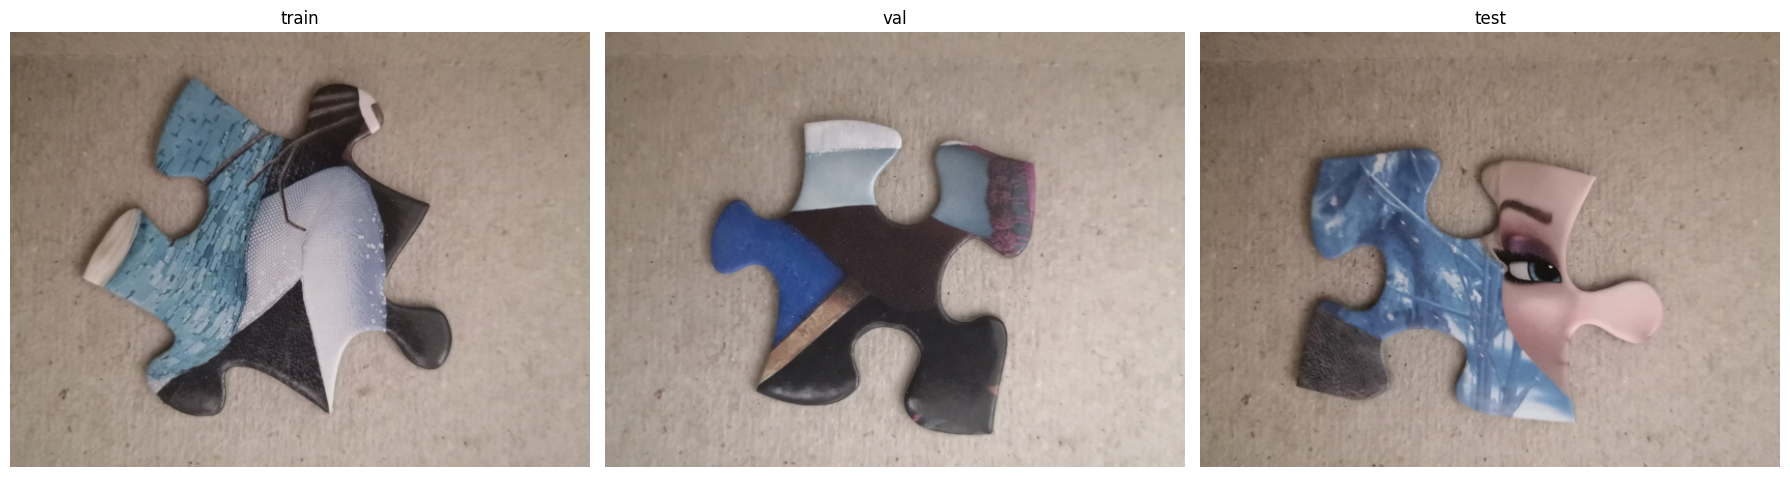

In [75]:
# Using Python Slices
def swap_channels_slicing(images):
    swapped_images = {}

    for key, img in images.items():
        # Swap channels using slicing (BGR to RGB)
        img_rgb = img[:,:,::-1]
        swapped_images[key] = img_rgb

    return swapped_images

# Swap channels
swapped_images = swap_channels_slicing(images)

# Display swapped images
display_color_images(swapped_images)

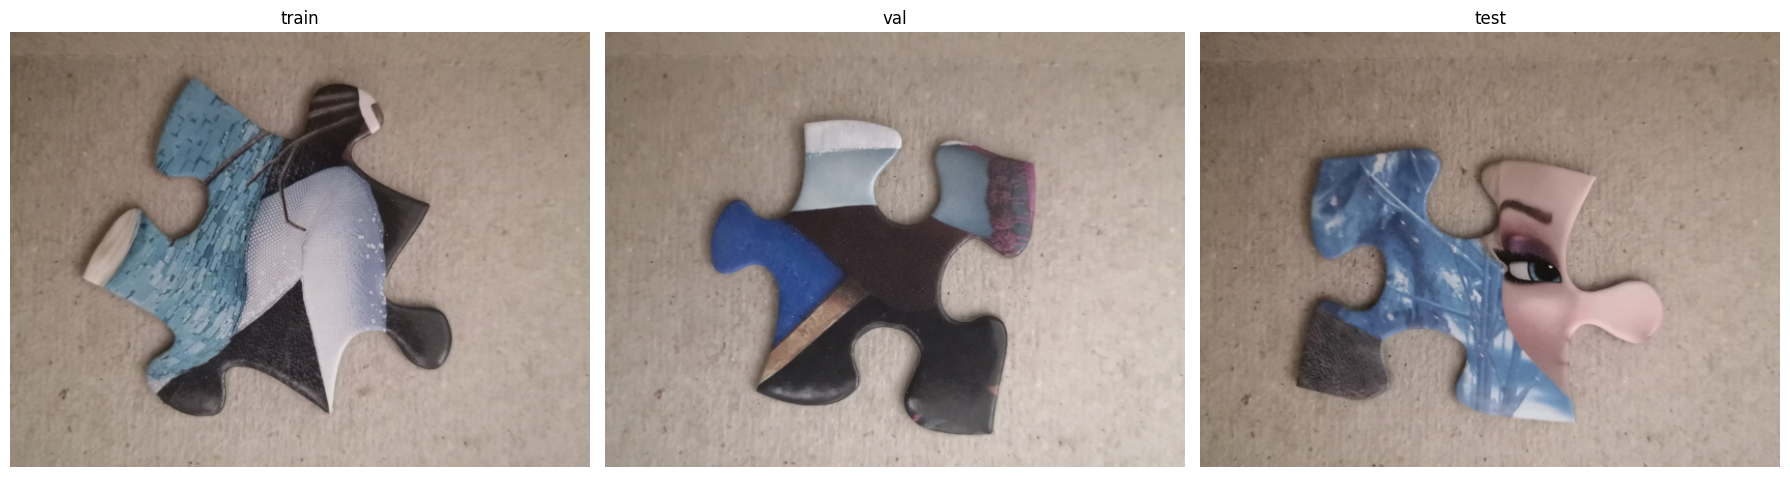

In [76]:
# Using np.moveaxis
import numpy as np

def swap_channels_moveaxis(images):
    swapped_images = {}

    for key, img in images.items():
        # Swap channels using np.moveaxis (BGR to RGB)
        img_rgb = np.moveaxis(img, -1, 0)[::-1]
        img_rgb = np.moveaxis(img_rgb, 0, -1)
        swapped_images[key] = img_rgb

    return swapped_images

# Swap channels
swapped_images = swap_channels_moveaxis(images)

# Display swapped images
display_color_images(swapped_images)

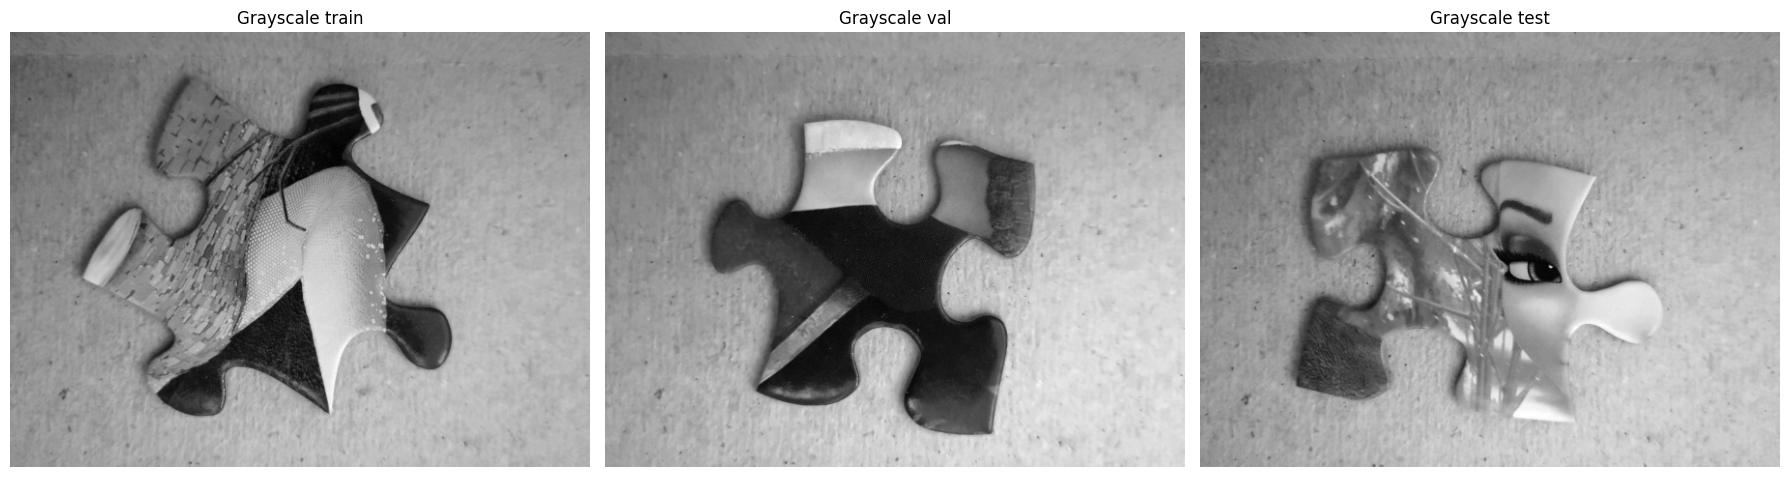

In [77]:
# Converting to Grayscale
def convert_and_display_grayscale(images):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (key, img) in enumerate(images.items()):
        # Convert image from BGR to RGB
        img_rgb = img[:,:,::-1]

        # Convert RGB image to grayscale
        img_gray = rgb2gray(img_rgb)

        axes[i].imshow(img_gray, cmap='gray')
        axes[i].set_title(f'Grayscale {key}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Convert and display grayscale images
convert_and_display_grayscale(images)

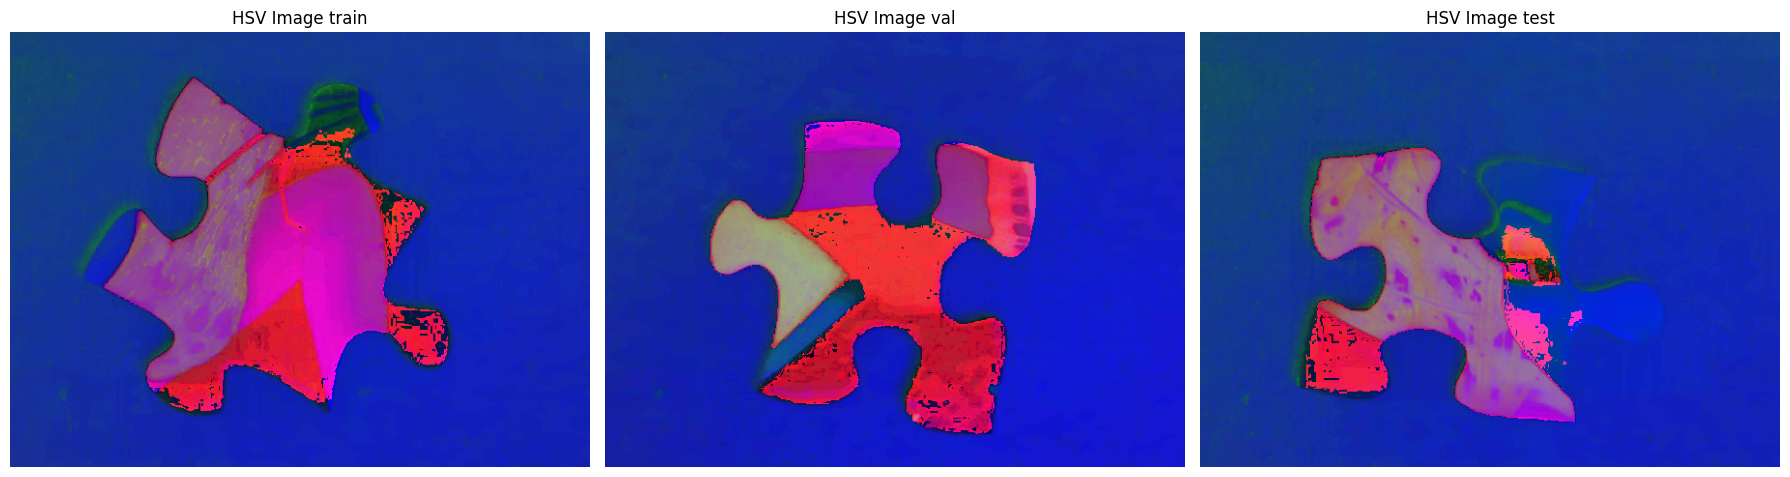

In [78]:
def convert_and_display_hsv(images):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (key, img) in enumerate(images.items()):
        # Convert image from BGR to RGB
        img_rgb = img[:,:,::-1]

        # Convert RGB image to HSV
        img_hsv = rgb2hsv(img_rgb)

        # Display the HSV image
        # HSV images are typically displayed in each channel: Hue, Saturation, Value
        axes[i].imshow(img_hsv)
        axes[i].set_title(f'HSV Image {key}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Convert and display HSV images
convert_and_display_hsv(images)

In [79]:
# Read the training image
training_image = images['train']

# Get the width and height
height, width, _ = training_image.shape

print(f'Width: {width}, Height: {height}')

Width: 600, Height: 450


In [80]:
# Read the training mask
training_mask = masks['train']

# Count white pixels (assuming white is represented by 255)
num_white_pixels = np.sum(training_mask == 255)

print(f'Number of white pixels in the mask is: {num_white_pixels}')

Number of white pixels in the mask is: 73196


In [81]:
# Read the grayscale version of the training image
training_image_gray = rgb2gray(images['train'])

In [82]:
max_pixel_value = np.max(training_image_gray)
print(f'Maximum pixel value in the image: {max_pixel_value}')

Maximum pixel value in the image: 0.8952407843137254


In [83]:
# Read the mask for the training image
training_mask = masks['train']

# Convert mask to boolean (where puzzle pixels are true)
puzzle_mask = training_mask > 0

# Maximum pixel value among puzzle pixels
max_pixel_value_puzzle = np.max(training_image_gray[puzzle_mask])
print(f'Maximum pixel value across all puzzle pixels: {max_pixel_value_puzzle}')

Maximum pixel value across all puzzle pixels: 0.8952407843137254


In [84]:
mean_pixel_intensity = np.mean(training_image_gray)
print(f'Mean pixel intensity in the image: {mean_pixel_intensity}')


Mean pixel intensity in the image: 0.5290321855061728


In [85]:
# Mean pixel value among puzzle pixels
mean_brightness_puzzle = np.mean(training_image_gray[puzzle_mask])
print(f'Mean brightness of the puzzle pixels: {mean_brightness_puzzle}')

Mean brightness of the puzzle pixels: 0.44892710651172446


In [86]:
# Inverse mask for background pixels
background_mask = ~puzzle_mask

# Mean pixel value among background pixels
mean_brightness_background = np.mean(training_image_gray[background_mask])
print(f'Mean brightness of the background pixels: {mean_brightness_background}')

Mean brightness of the background pixels: 0.5599243676982532


In [87]:
# Variance of pixel values among puzzle pixels
variance_puzzle = np.var(training_image_gray[puzzle_mask])
print(f'Variance in grayscale intensities for puzzle pixels: {variance_puzzle}')

Variance in grayscale intensities for puzzle pixels: 0.03874218774620814


In [88]:
# Variance of pixel values among background pixels
variance_background = np.var(training_image_gray[background_mask])
print(f'Variance in grayscale intensities for background pixels: {variance_background}')

Variance in grayscale intensities for background pixels: 0.00798714743001321


In [89]:
training_image = swapped_images['train']

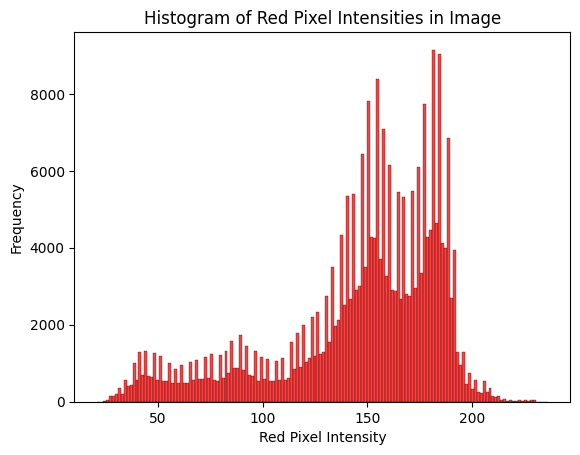

In [90]:
# 10. Display histogram of red pixel intensities
sns.histplot(training_image[:,:,0].flatten(), kde=False, color='red')
plt.title('Histogram of Red Pixel Intensities in Image')
plt.xlabel('Red Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

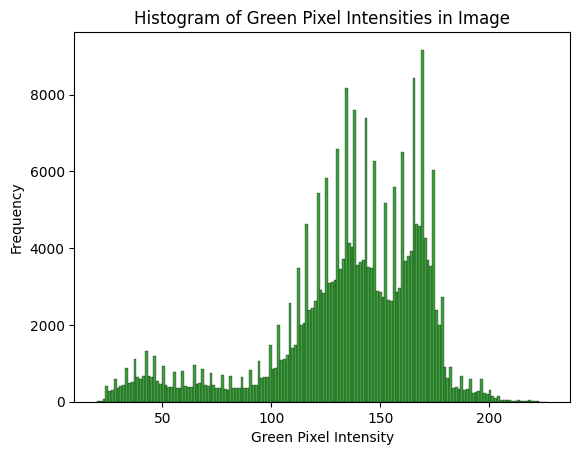

In [91]:
# 11. Display histogram of green pixel intensities
sns.histplot(training_image[:,:,1].flatten(), kde=False, color='green')
plt.title('Histogram of Green Pixel Intensities in Image')
plt.xlabel('Green Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

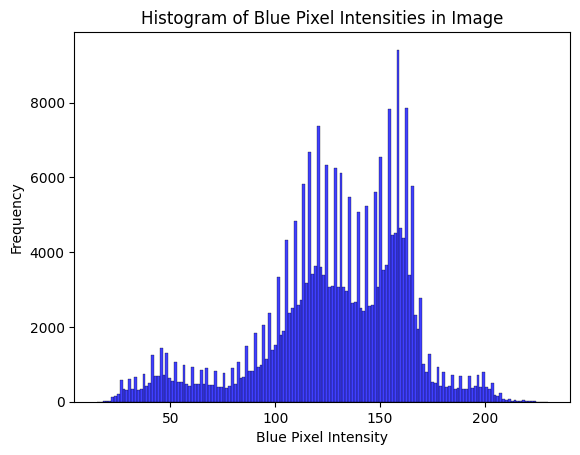

In [92]:
# 12. Display histogram of blue pixel intensities
sns.histplot(training_image[:,:,2].flatten(), kde=False, color='blue')
plt.title('Histogram of Blue Pixel Intensities in Image')
plt.xlabel('Blue Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

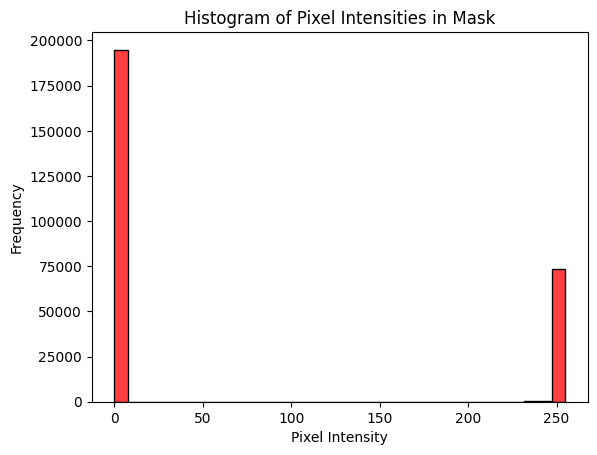

In [93]:
# 10. Display histogram of pixel intensities for Mask
sns.histplot(masks['train'].flatten(), kde=False, color='red')
plt.title('Histogram of Pixel Intensities in Mask')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

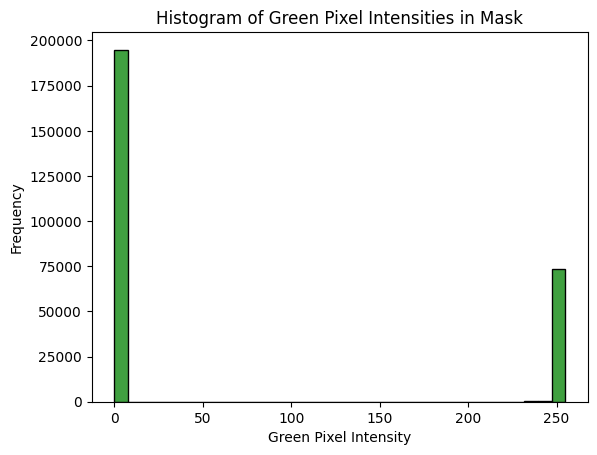

In [94]:
# 11. Display histogram of green pixel intensities for Mask
sns.histplot(masks['train'].flatten(), kde=False, color='green')
plt.title('Histogram of Green Pixel Intensities in Mask')
plt.xlabel('Green Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

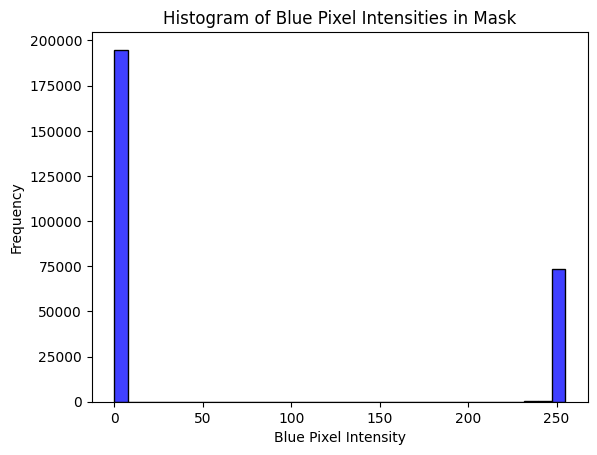

In [95]:
# 12. Display histogram of blue pixel intensities for Mask
sns.histplot(masks['train'].flatten(), kde=False, color='blue')
plt.title('Histogram of Blue Pixel Intensities in Mask')
plt.xlabel('Blue Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

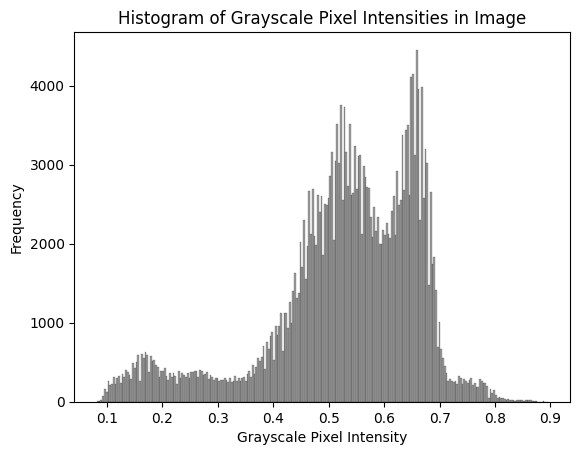

In [96]:
# 10. Display histogram of grayscale pixel intensities
sns.histplot(training_image_gray.flatten(), bins = 256, kde=False, color='gray')
plt.title('Histogram of Grayscale Pixel Intensities in Image')
plt.xlabel('Grayscale Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [97]:
hsv_image = rgb2hsv(swapped_images['train'])

Text(0, 0.5, 'Frequency')

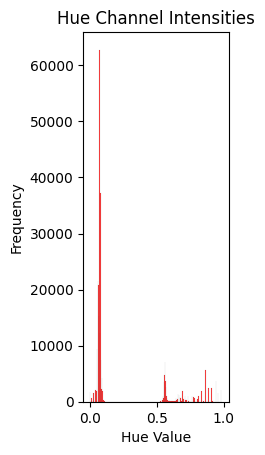

In [98]:
# Hue channel histogram
plt.subplot(1, 3, 1)
sns.histplot(hsv_image[:,:,0].flatten(), bins=256, color='red', kde=False)
plt.title('Hue Channel Intensities')
plt.xlabel('Hue Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

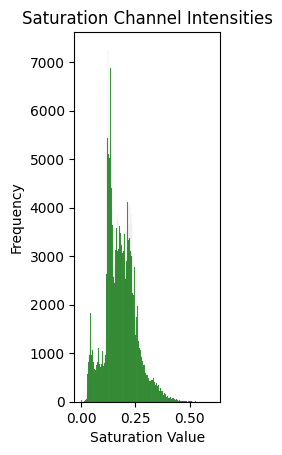

In [99]:
# Saturation channel histogram
plt.subplot(1, 3, 2)
sns.histplot(hsv_image[:, :, 1].ravel(), bins=256, color='green', kde=False)
plt.title('Saturation Channel Intensities')
plt.xlabel('Saturation Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

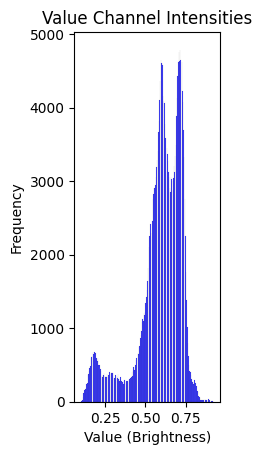

In [100]:
# Value channel histogram
plt.subplot(1, 3, 3)
sns.histplot(hsv_image[:, :, 2].ravel(), bins=256, color='blue', kde=False)
plt.title('Value Channel Intensities')
plt.xlabel('Value (Brightness)')
plt.ylabel('Frequency')

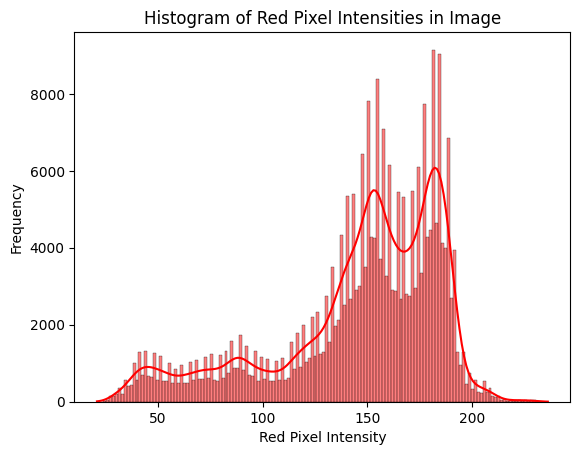

In [101]:
# 10. Display histogram of red pixel intensities
sns.histplot(training_image[:,:,0].flatten(), kde=True, color='red')
plt.title('Histogram of Red Pixel Intensities in Image')
plt.xlabel('Red Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

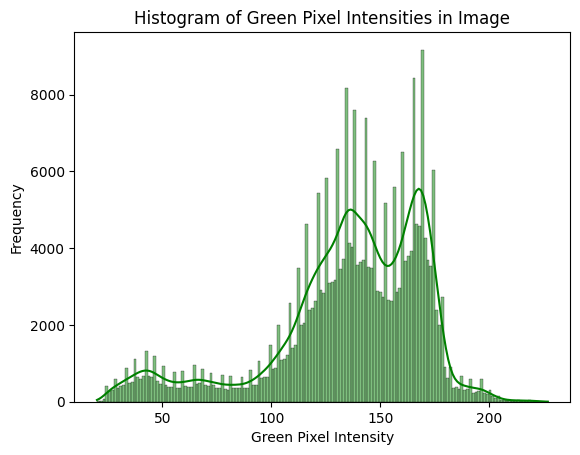

In [102]:
# 11. Display histogram of green pixel intensities
sns.histplot(training_image[:,:,1].flatten(), kde=True, color='green')
plt.title('Histogram of Green Pixel Intensities in Image')
plt.xlabel('Green Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

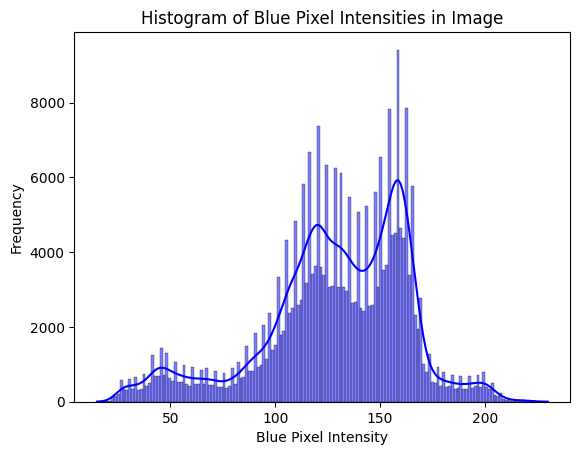

In [103]:
# 12. Display histogram of blue pixel intensities
sns.histplot(training_image[:,:,2].flatten(), kde=True, color='blue')
plt.title('Histogram of Blue Pixel Intensities in Image')
plt.xlabel('Blue Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

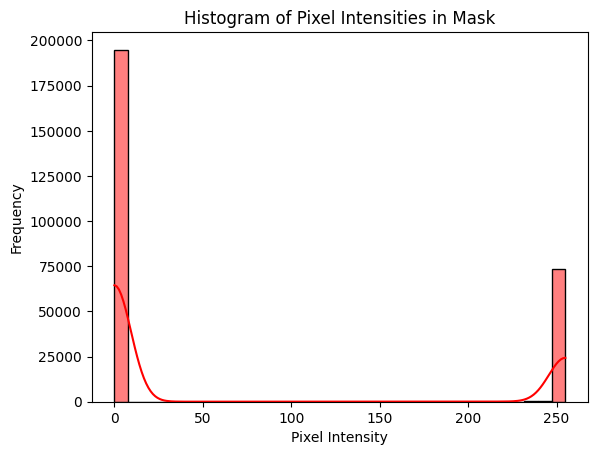

In [104]:
# 10. Display histogram of pixel intensities for Mask
sns.histplot(masks['train'].flatten(), kde=True, color='red')
plt.title('Histogram of Pixel Intensities in Mask')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

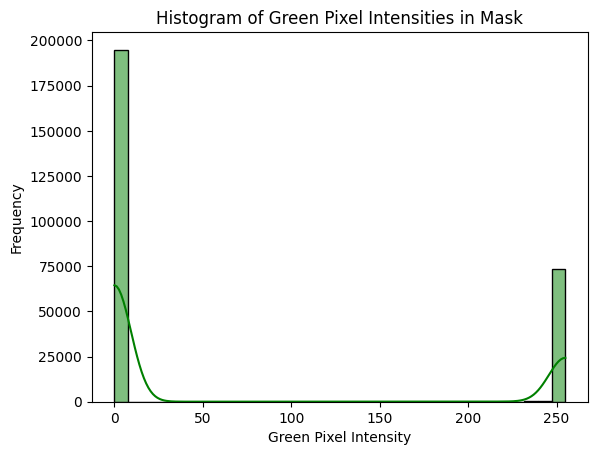

In [105]:
# 11. Display histogram of green pixel intensities for Mask
sns.histplot(masks['train'].flatten(), kde=True, color='green')
plt.title('Histogram of Green Pixel Intensities in Mask')
plt.xlabel('Green Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

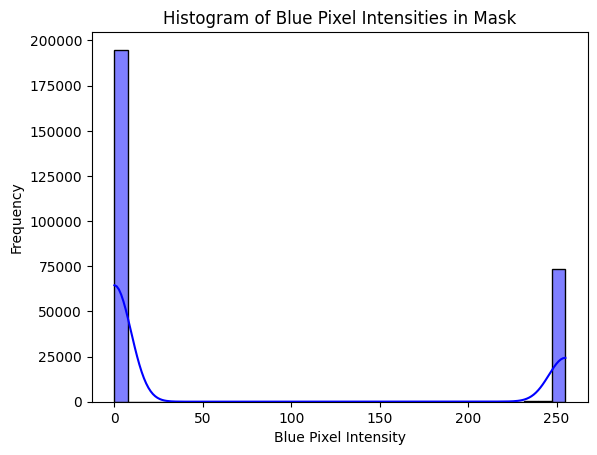

In [106]:
# 12. Display histogram of blue pixel intensities for Mask
sns.histplot(masks['train'].flatten(), kde=True, color='blue')
plt.title('Histogram of Blue Pixel Intensities in Mask')
plt.xlabel('Blue Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

## I noticed that the histogram has bars only around the values 0 and 250, with that of the 0 relatively higher than the 250 one. This indicates that most of the pixel values in our mask are either very low (0) or very high (close to 255).

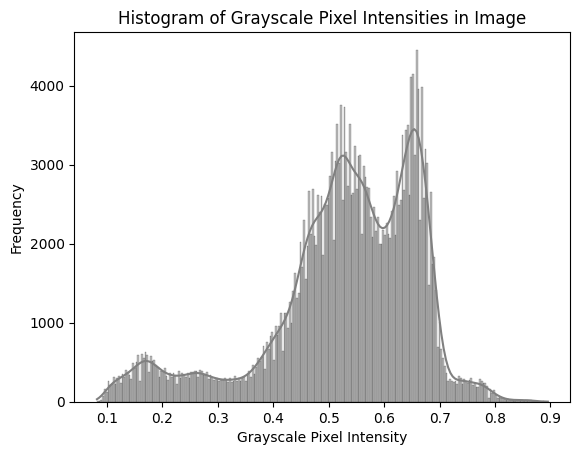

In [107]:
# 10. Display histogram of grayscale pixel intensities
sns.histplot(training_image_gray.flatten(), bins = 256, kde=True, color='gray')
plt.title('Histogram of Grayscale Pixel Intensities in Image')
plt.xlabel('Grayscale Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [108]:
hsv_image = rgb2hsv(swapped_images['train'])

Text(0, 0.5, 'Frequency')

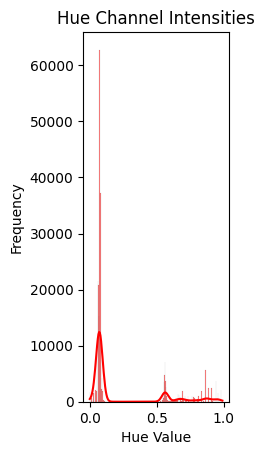

In [109]:
# Hue channel histogram
plt.subplot(1, 3, 1)
sns.histplot(hsv_image[:,:,0].flatten(), bins=256, color='red', kde=True)
plt.title('Hue Channel Intensities')
plt.xlabel('Hue Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

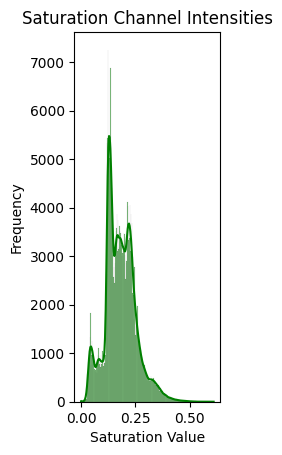

In [110]:
# Saturation channel histogram
plt.subplot(1, 3, 2)
sns.histplot(hsv_image[:, :, 1].ravel(), bins=256, color='green', kde=True)
plt.title('Saturation Channel Intensities')
plt.xlabel('Saturation Value')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

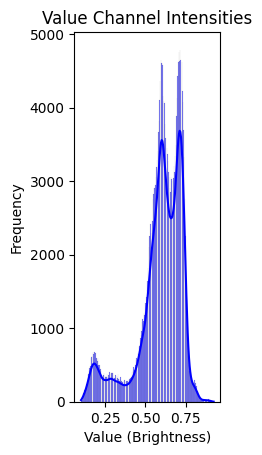

In [111]:
# Value channel histogram
plt.subplot(1, 3, 3)
sns.histplot(hsv_image[:, :, 2].ravel(), bins=256, color='blue', kde=True)
plt.title('Value Channel Intensities')
plt.xlabel('Value (Brightness)')
plt.ylabel('Frequency')

In [112]:
from google.colab.patches import cv2_imshow # Import the Colab patch for imshow

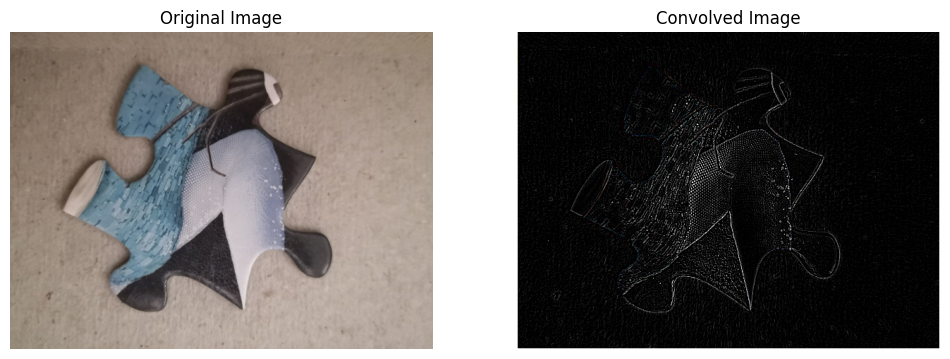

In [113]:
def apply_convolution(image, kernel):

    # Ensure image is in float32 format
    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    # Convert the image to the same dtype as the kernel
    image = image.astype(np.float32)

    # Get kernel size and image size
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2

    # Pad the image to maintain size after convolution
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=0)

    # Prepare an empty array for the result with the correct dimensions
    result = np.zeros_like(padded_image) # Initialize result with the size of padded_image

    # Apply convolution for each channel
    for i in range(image.shape[2]):
        result[:, :, i] = cv2.filter2D(padded_image[:, :, i], -1, kernel)

    # Crop the result to match the original image size # Crop the result back to the original image size
    result = result[pad_size:-pad_size, pad_size:-pad_size, :]

    return result

# ... (rest of the code remains the same)

def main():
    # Load image
    image_path = '/content/drive/My Drive/img/image-35.jpg'  # Replace with your image path
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert image to float32
    image = image.astype(np.float32) / 255.0

    # Define a sample kernel (e.g., edge detection kernel)
    kernel = np.array([[-1, -1, -1],
                       [-1,  8, -1],
                       [-1, -1, -1]], dtype=np.float32)

    # Apply convolution
    convolved_image = apply_convolution(image, kernel)

    # Convert back to uint8 for display
    convolved_image = np.clip(convolved_image * 255, 0, 255).astype(np.uint8)
    image = np.clip(image * 255, 0, 255).astype(np.uint8)

    # Display original and convolved images using Matplotlib
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(convolved_image, cv2.COLOR_BGR2RGB))
    plt.title('Convolved Image')
    plt.axis('off')

    plt.show()

if __name__ == "__main__":
    main()


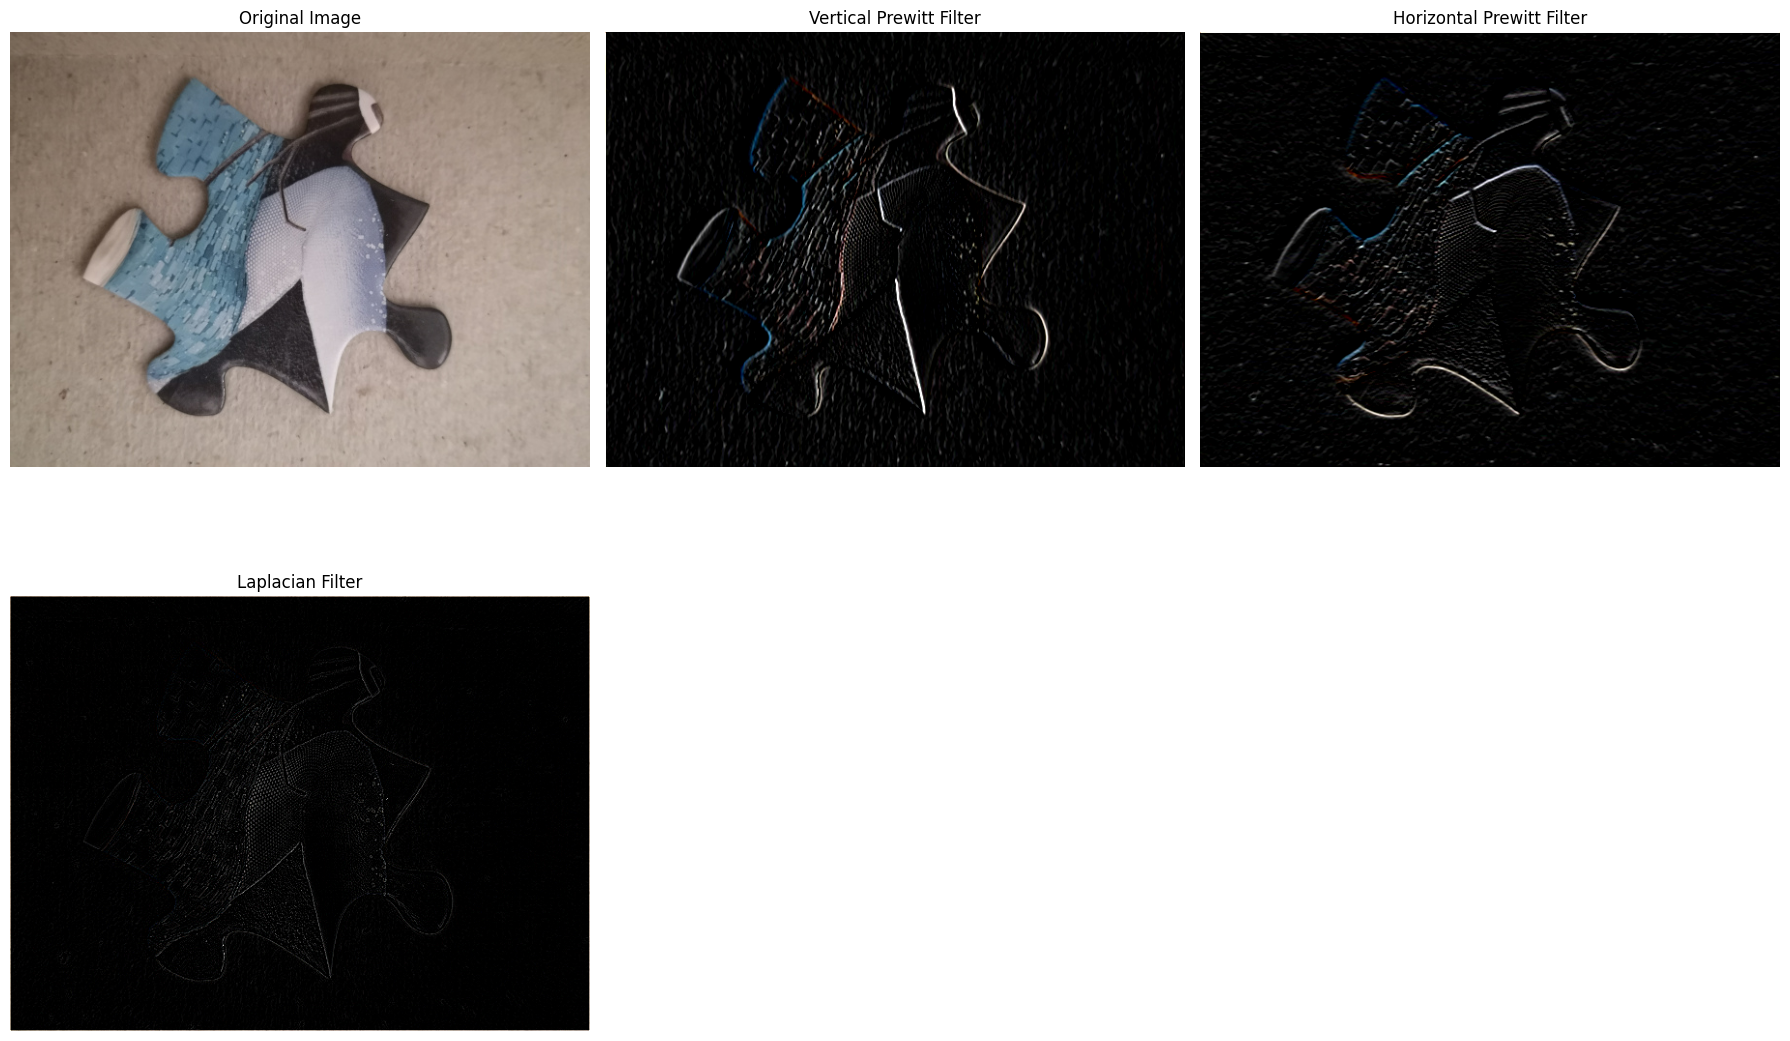

In [114]:
def apply_convolution(image, kernel):

    # Ensure image is in float32 format
    if image.dtype != np.float32:
        image = image.astype(np.float32) / 255.0

    # Get kernel size and image size
    kernel_size = kernel.shape[0]
    pad_size = kernel_size // 2

    # Pad the image to maintain size after convolution
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='constant', constant_values=0)

    # Prepare an empty array for the result
    result = np.zeros_like(image) # Initialize result with the size of the original image, not the padded one

    # Apply convolution for each channel
    for i in range(image.shape[2]):
        # Crop the result of filter2D to match the original image size
        result[:, :, i] = cv2.filter2D(padded_image[:, :, i], -1, kernel)[pad_size:-pad_size, pad_size:-pad_size]

    return result

def main():
    # Load image
    image_path = '/content/drive/My Drive/img/image-35.jpg'  # Replace with your image path
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert image to float32
    image = image.astype(np.float32) / 255.0

    # Define filters
    vertical_prewitt = np.array([[-1, 0, 1],
                                 [-1, 0, 1],
                                 [-1, 0, 1]], dtype=np.float32)

    horizontal_prewitt = np.array([[-1, -1, -1],
                                   [0,  0,  0],
                                   [1,  1,  1]], dtype=np.float32)

    laplacian = np.array([[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]], dtype=np.float32)

    # Apply filters
    vertical_prewitt_image = apply_convolution(image, vertical_prewitt)
    horizontal_prewitt_image = apply_convolution(image, horizontal_prewitt)
    laplacian_image = apply_convolution(image, laplacian)

    # Convert back to uint8 for display
    vertical_prewitt_image = np.clip(vertical_prewitt_image * 255, 0, 255).astype(np.uint8)
    horizontal_prewitt_image = np.clip(horizontal_prewitt_image * 255, 0, 255).astype(np.uint8)
    laplacian_image = np.clip(laplacian_image * 255, 0, 255).astype(np.uint8)
    image = np.clip(image * 255, 0, 255).astype(np.uint8)

    # Display images using Matplotlib
    plt.figure(figsize=(18, 12))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Vertical Prewitt Filter
    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(vertical_prewitt_image, cv2.COLOR_BGR2RGB))
    plt.title('Vertical Prewitt Filter')
    plt.axis('off')

    # Horizontal Prewitt Filter
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(horizontal_prewitt_image, cv2.COLOR_BGR2RGB))
    plt.title('Horizontal Prewitt Filter')
    plt.axis('off')

    # Laplacian Filter
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(laplacian_image, cv2.COLOR_BGR2RGB))
    plt.title('Laplacian Filter')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


## What is the difference between the output of your convolution function from question 1, and the output of cv2.filter2D when you apply the filters above?

In [115]:
import scipy.stats

def compute_features(image, vertical_prewitt, horizontal_prewitt, laplacian):

    # Apply filters to each channel
    vertical_prewitt_image = apply_convolution(image, vertical_prewitt)
    horizontal_prewitt_image = apply_convolution(image, horizontal_prewitt)
    laplacian_image = apply_convolution(image, laplacian)

    # Stack features
    features = np.stack([
        vertical_prewitt_image[:, :, 0],  # PrewittV R
        horizontal_prewitt_image[:, :, 0], # PrewittHR
        vertical_prewitt_image[:, :, 1],  # PrewittV G
        horizontal_prewitt_image[:, :, 1], # PrewittHG
        vertical_prewitt_image[:, :, 2],  # PrewittV B
        horizontal_prewitt_image[:, :, 2], # PrewittHB
        laplacian_image[:, :, 0],         # Laplacian R
        laplacian_image[:, :, 1],         # Laplacian G
        laplacian_image[:, :, 2],         # Laplacian B
        image[:, :, 0],                   # R
        image[:, :, 1],                   # G
        image[:, :, 2],                   # B
        cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 0], # H
        cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 1], # S
        cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 2]  # V
    ], axis=-1)

    return features

In [116]:
def calculate_mean_and_covariance(features, mask):

    # Extract foreground and background features
    fg_features = features[mask > 0]
    bg_features = features[mask == 0]

    # Calculate mean and covariance for foreground pixels
    mean_fg = np.mean(fg_features, axis=0)
    cov_fg = np.cov(fg_features, rowvar=False)

    # Calculate mean and covariance for background pixels
    mean_bg = np.mean(bg_features, axis=0)
    cov_bg = np.cov(bg_features, rowvar=False)

    return mean_fg, cov_fg, mean_bg, cov_bg

In [117]:
def classify_pixels(features, mean_fg, cov_fg, mean_bg, cov_bg, p_fg, p_bg, threshold):

    # Calculate likelihoods, adding a small value to the diagonal to ensure positive definiteness
    likelihood_fg = scipy.stats.multivariate_normal.pdf(features, mean=mean_fg, cov=cov_fg + 1e-6 * np.eye(cov_fg.shape[0]))
    likelihood_bg = scipy.stats.multivariate_normal.pdf(features, mean=mean_bg, cov=cov_bg + 1e-6 * np.eye(cov_bg.shape[0]))

    # Compute posterior probabilities
    posterior_fg = (likelihood_fg * p_fg) / ((likelihood_fg * p_fg) + (likelihood_bg * p_bg))

    # Classify pixels
    classification = (posterior_fg >= threshold).astype(np.uint8)

    return classification

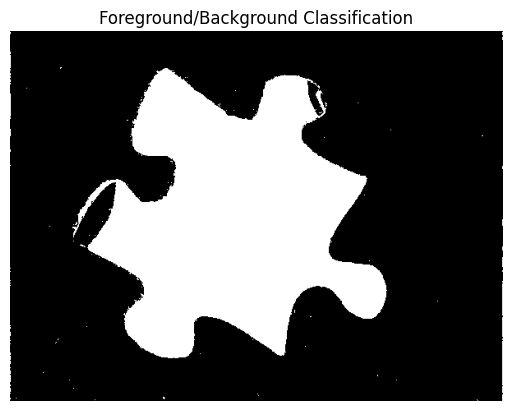

In [118]:
def main():
    # Load image and mask
    image_path = '/content/drive/My Drive/img/image-35.jpg'  # Replace with your image path
    mask_path = '/content/drive/My Drive/mask/mask-35.png'    # Replace with your mask path
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if images loaded successfully
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return
    if mask is None:
        print(f"Error: Could not load mask from {mask_path}")
        return

    # Convert image to float32
    image = image.astype(np.float32) / 255.0

    # Define filters
    vertical_prewitt = np.array([[-1, 0, 1],
                                 [-1, 0, 1],
                                 [-1, 0, 1]], dtype=np.float32)

    horizontal_prewitt = np.array([[-1, -1, -1],
                                   [0,  0,  0],
                                   [1,  1,  1]], dtype=np.float32)

    laplacian = np.array([[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]], dtype=np.float32)

    # Compute features
    features = compute_features(image, vertical_prewitt, horizontal_prewitt, laplacian)

    # Calculate mean and covariance for foreground and background
    mean_fg, cov_fg, mean_bg, cov_bg = calculate_mean_and_covariance(features, mask)

    # Compute prior probabilities
    p_fg = np.sum(mask > 0) / mask.size
    p_bg = np.sum(mask == 0) / mask.size

    # Classify pixels
    threshold = 0.9  # Example threshold
    classification = classify_pixels(features, mean_fg, cov_fg, mean_bg, cov_bg, p_fg, p_bg, threshold)

    # Display classification result
    plt.imshow(classification, cmap='gray')
    plt.title('Foreground/Background Classification')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

In [119]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def classify_pixels(features, mean_fg, cov_fg, mean_bg, cov_bg, p_fg, p_bg, thresholds):
    """
    Classifies each pixel as foreground or background based on the posterior probability.

    Parameters:
    - features (numpy.ndarray): Extracted features from the image.
    - mean_fg (numpy.ndarray): Mean vector for foreground pixels.
    - cov_fg (numpy.ndarray): Covariance matrix for foreground pixels.
    - mean_bg (numpy.ndarray): Mean vector for background pixels.
    - cov_bg (numpy.ndarray): Covariance matrix for background pixels.
    - p_fg (float): Prior probability of foreground.
    - p_bg (float): Prior probability of background.
    - thresholds (list): List of threshold values for classification.

    Returns:
    - classification_results (dict): Dictionary containing classification results for each threshold.
    """
    # Calculate likelihoods
    likelihood_fg = scipy.stats.multivariate_normal.pdf(features, mean=mean_fg, cov=cov_fg)
    likelihood_bg = scipy.stats.multivariate_normal.pdf(features, mean=mean_bg, cov=cov_bg)

    # Compute posterior probabilities
    posterior_fg = (likelihood_fg * p_fg) / ((likelihood_fg * p_fg) + (likelihood_bg * p_bg))

    # Initialize results dictionary
    classification_results = {}

    for threshold in thresholds:
        # Classify pixels
        classification = (posterior_fg >= threshold).astype(np.uint8)

        # Store classification results
        classification_results[threshold] = classification

    return classification_results

In [120]:
def evaluate_performance(true_mask, classification_results):
    """
    Evaluates performance metrics (accuracy, precision, recall, F1 score) and plots ROC curve.

    Parameters:
    - true_mask (numpy.ndarray): Ground truth mask for evaluation.
    - classification_results (dict): Dictionary containing classification results for each threshold.

    Returns:
    - auc (float): Area Under the Curve (AUC) for ROC.
    """
    y_true = (true_mask > 0).astype(np.uint8).flatten()  # Flatten mask for comparison
    roc_auc = []
    fpr_list, tpr_list, thresholds = [], [], []

    for threshold, pred_mask in classification_results.items():
        y_pred = pred_mask.flatten()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        print(f"Threshold {threshold} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{cm}\n")

        # Calculate ROC metrics
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc.append(roc_auc_score(y_true, y_pred))
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thresholds.append(threshold)

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    for fpr, tpr, threshold in zip(fpr_list, tpr_list, thresholds):
        plt.plot(fpr, tpr, label=f'Threshold {threshold:.2f} (AUC = {roc_auc[thresholds.index(threshold)]:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Return the AUC of the best threshold
    best_auc = max(roc_auc)
    return best_auc

In [121]:
def main():
    # Load validation image and mask
    validation_image_path = '/content/drive/My Drive/img/image-83.jpg'  # Replace with your validation image path
    validation_mask_path = '/content/drive/My Drive/mask/mask-83.png'    # Replace with your validation mask path
    validation_image = cv2.imread(validation_image_path, cv2.IMREAD_COLOR)
    validation_mask = cv2.imread(validation_mask_path, cv2.IMREAD_GRAYSCALE)

    # Convert image to float32
    validation_image = validation_image.astype(np.float32) / 255.0

    # Define filters
    vertical_prewitt = np.array([[-1, 0, 1],
                                 [-1, 0, 1],
                                 [-1, 0, 1]], dtype=np.float32)

    horizontal_prewitt = np.array([[-1, -1, -1],
                                   [0,  0,  0],
                                   [1,  1,  1]], dtype=np.float32)

    laplacian = np.array([[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]], dtype=np.float32)

    # Compute features for validation image
    validation_features = compute_features(validation_image, vertical_prewitt, horizontal_prewitt, laplacian)

    # Use parameters from training phase
    # Replace with actual values from training phase

    # Define thresholds
    thresholds = np.linspace(0.01, 0.99, 10)  # Example thresholds from 0.01 to 0.99

    # Classify pixels
    classification_results = classify_pixels(validation_features, mean_fg, cov_fg, mean_bg, cov_bg, p_fg, p_bg, thresholds)

    # Evaluate performance
    auc = evaluate_performance(validation_mask, classification_results)
    print(f"Best AUC: {auc:.4f}")

if __name__ == "__main__":
    main()

NameError: name 'mean_fg' is not defined